In [1]:
from Helpers.bvp import BVP
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.integrate import solve_ivp
from math import ceil

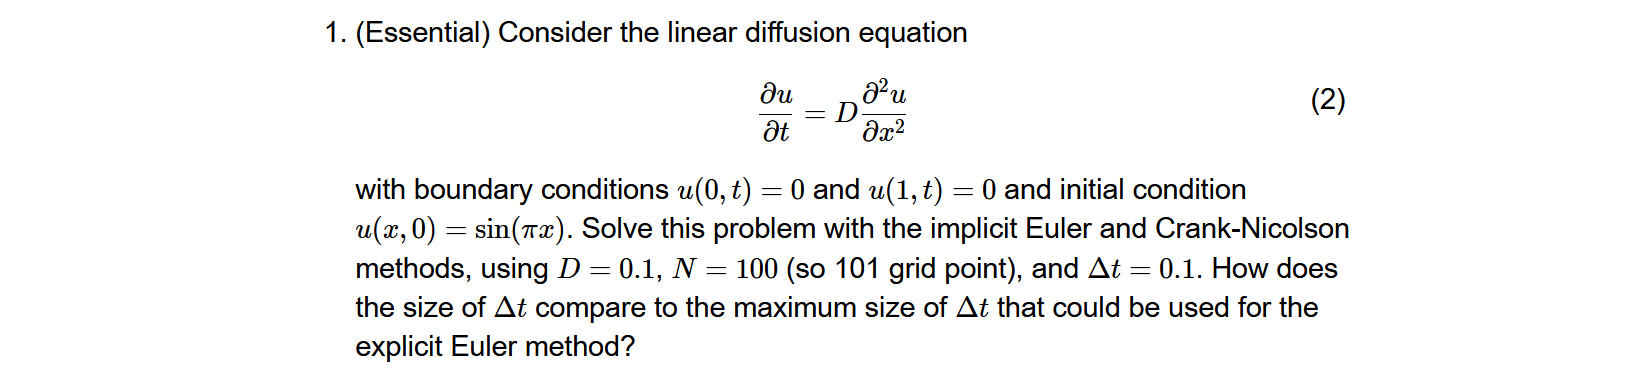

In [19]:
a = 0
b = 1
alpha = 0
beta = 0
N = 100
D = 0.1

f_fun = lambda x, t: np.sin(np.pi * x)

bvp = BVP(a, b, N, alpha, beta, D_const=D, condition_type='Dirichlet', f_fun=f_fun)

t_boundary = 0
dt = 0.0001
t_final = 2

solution, t = bvp.solve_PDE(t_boundary, dt, t_final)

# Find the exact solution when x = 0.5, t = 2
idx = np.where(bvp.x_values == 0.5)[0][0]
print('x: ', bvp.x_values[idx], 't: ', t[-1])

numeric = solution[idx, -1]
exact = np.exp(-0.2 * np.pi**2)

print('Numeric solution: ', numeric)
print('Exact solution: ', exact)
print('Close: ', np.isclose(numeric, exact, rtol=1e-3))

x:  0.5 t:  2.0
Numeric solution:  0.13896159771350083
Exact solution:  0.13891113314280026
Close:  True
